In [109]:
# CELL_ID: 07_generation_v2_imports
# ============================================================================
# IMPORT DEPENDENCIES
# ============================================================================

# %pip install langchain langchain-ollama langgraph pydantic chromadb --quiet

import json
import os
from pathlib import Path
from typing import List, Dict, Any, Optional, Literal, TypedDict, Union
from enum import Enum

# LangChain imports
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool, ToolRuntime

# LangGraph imports
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.types import RetryPolicy
from langgraph.config import get_stream_writer
from langchain.agents.middleware import wrap_tool_call

# LangChain agents (v1 - replaces create_react_agent)
from langchain.agents import create_agent

# Pydantic for structured outputs
from pydantic import BaseModel, Field

# ChromaDB
import chromadb
from chromadb.config import Settings

print("✓ Imports loaded successfully")


✓ Imports loaded successfully


In [111]:
# CELL_ID: 07_generation_v2_chromadb_reader
# ============================================================================
# CHROMADB READER CLASS (REUSED FROM 06_generation_v1)
# ============================================================================

class ChromaDBReader:
    """
    Handles reading/searching from Chroma DB with Jina embedding function.
    Reused from 06_generation_v1.ipynb.
    """
    
    def __init__(
        self,
        chroma_db_path: str = "./chroma_db",
        collection_name: str = "diabetes_guidelines_v1",
        embedding_function = None
    ):
        self.chroma_db_path = Path(chroma_db_path)
        self.collection_name = collection_name
        self.embedding_function = embedding_function
        self.client = None
        self.collection = None
    
    def initialize(self):
        """Initialize ChromaDB client and collection."""
        if self.client is None:
            self.client = chromadb.PersistentClient(
                path=str(self.chroma_db_path),
                settings=Settings(
                    anonymized_telemetry=False,
                    allow_reset=True
                )
            )
            print(f"✓ ChromaDB client initialized: {self.chroma_db_path}")
        
        try:
            self.collection = self.client.get_collection(name=self.collection_name)
            print(f"✓ Loaded collection: {self.collection_name}")
            print(f"  • Total chunks: {self.collection.count()}")
        except Exception as e:
            if self.embedding_function:
                self.collection = self.client.get_collection(
                    name=self.collection_name,
                    embedding_function=self.embedding_function
                )
                print(f"✓ Loaded collection: {self.collection_name}")
                print(f"  • Total chunks: {self.collection.count()}")
            else:
                raise Exception(f"Collection '{self.collection_name}' not found. Make sure you've run 04_vector_store_v1.ipynb first.")
    
    def _unflatten_metadata(self, flat_metadata: Dict) -> Dict:
        """Unflatten metadata (parse JSON strings back to objects)."""
        unflattened = {}
        for key, value in flat_metadata.items():
            try:
                if isinstance(value, str) and (value.startswith('[') or value.startswith('{')):
                    unflattened[key] = json.loads(value)
                else:
                    unflattened[key] = value
            except:
                unflattened[key] = value
        return unflattened
    
    def search(self, query: str, n_results: int = 5, where: Dict = None, min_similarity: float = 0.4) -> List[Dict]:
        """
        Search the collection with semantic search.
        
        Args:
            query: Search query text
            n_results: Number of results to return
            where: Optional metadata filter
            min_similarity: Minimum relevance score (0-1), default 0.4
            
        Returns:
            List of result dictionaries with content, metadata, and relevance score
            Only chunks with relevance_score >= min_similarity are returned
        """
        if not self.collection:
            self.initialize()
        
        results = self.collection.query(
            query_texts=[query],
            n_results=n_results,
            where=where,
            include=['documents', 'metadatas', 'distances']
        )
        
        # Format results and filter by similarity
        formatted_results = []
        seen_chunk_ids = set()
        
        for i in range(len(results['ids'][0])):
            chunk_id = results['ids'][0][i]
            relevance_score = 1 - results['distances'][0][i]
            
            # Filter by minimum similarity
            if relevance_score < min_similarity:
                continue
            
            # Deduplicate
            if chunk_id in seen_chunk_ids:
                continue
            
            chunk_data = {
                'chunk_id': chunk_id,
                'content': results['documents'][0][i],
                'metadata': self._unflatten_metadata(results['metadatas'][0][i]),
                'relevance_score': relevance_score,
                'distance': results['distances'][0][i]
            }
            formatted_results.append(chunk_data)
            seen_chunk_ids.add(chunk_id)
        
        return formatted_results

print("✓ ChromaDBReader class loaded")


✓ ChromaDBReader class loaded


In [112]:
# CELL_ID: 07_generation_v2_jina_embedding
# ============================================================================
# JINA EMBEDDING FUNCTION (REUSED FROM 06_generation_v1)
# ============================================================================

import requests
import time

class JinaEmbeddingFunction:
    """
    Custom embedding function for ChromaDB using Jina API.
    Reused from 06_generation_v1.ipynb.
    """
    
    def __init__(
        self,
        api_key: str = "jina_dc47aa711aa944799688c5c6f82215595xhVihTxOWOBR7-ZK0LXOM3g3oxY",
        model: str = "jina-embeddings-v4",
        task: str = "text-matching",
        api_url: str = "https://api.jina.ai/v1/embeddings",
        batch_size: int = 10,
        max_retries: int = 3
    ):
        self.api_key = api_key or os.getenv("JINA_API_KEY")
        if not self.api_key:
            raise ValueError("JINA_API_KEY environment variable is required. Set it with: export JINA_API_KEY=your_api_key")
        self.model = model
        self.task = task
        self.api_url = api_url
        self.batch_size = batch_size
        self.max_retries = max_retries
        self.headers = {
            'Content-Type': 'application/json',
            'Authorization': f'Bearer {self.api_key}'
        }
    
    def name(self) -> str:
        return "jina-embeddings-v4"
    
    def __call__(self, input):
        """Generate embeddings for input text(s)."""
        if isinstance(input, str):
            texts = [input]
        else:
            texts = input
        
        if not texts:
            return []
        
        all_embeddings = []
        for i in range(0, len(texts), self.batch_size):
            batch = texts[i:i + self.batch_size]
            batch_embeddings = self._embed_batch(batch)
            all_embeddings.extend(batch_embeddings)
        
        return all_embeddings
    
    def _embed_batch(self, texts: List[str]) -> List[List[float]]:
        """Embed a batch of texts using Jina API."""
        data = {
            "model": self.model,
            "task": self.task,
            "input": [{"text": text} for text in texts]
        }
        
        for attempt in range(self.max_retries):
            try:
                response = requests.post(
                    self.api_url,
                    headers=self.headers,
                    json=data,
                    timeout=60
                )
                response.raise_for_status()
                
                result = response.json()
                embeddings = []
                if 'data' in result:
                    for item in result['data']:
                        if 'embedding' in item:
                            embeddings.append(item['embedding'])
                    return embeddings
                else:
                    raise ValueError(f"Unexpected API response format: {result}")
                    
            except requests.exceptions.RequestException as e:
                if attempt < self.max_retries - 1:
                    wait_time = 2 ** attempt
                    print(f"⚠ API request failed (attempt {attempt + 1}/{self.max_retries}), retrying in {wait_time}s...")
                    time.sleep(wait_time)
                else:
                    raise Exception(f"Failed to get embeddings after {self.max_retries} attempts: {e}")
        
        return []

print("✓ JinaEmbeddingFunction class loaded")


✓ JinaEmbeddingFunction class loaded


In [113]:
# CELL_ID: 07_generation_v2_llm_setup
# ============================================================================
# LLM CONFIGURATION (OLLAMA)
# ============================================================================

# Ollama configuration
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
OLLAMA_MODEL = "minimax-m2:cloud"

print("=" * 60)
print("LLM CONFIGURATION")
print("=" * 60)
print(f"Ollama Base URL: {OLLAMA_BASE_URL}")
print(f"Model: {OLLAMA_MODEL}")
print("=" * 60)

# Initialize Ollama LLM
llm = ChatOllama(
    model=OLLAMA_MODEL,
    base_url=OLLAMA_BASE_URL,
    temperature=0.1  # Low temperature for consistent structured outputs
    # num_ctx=4096  # Context window
)

# Test LLM connection
try:
    test_response = llm.invoke("Say 'OK' if you can read this.")
    print(f"✓ LLM connection successful: {test_response.content[:50]}")
except Exception as e:
    print(f"⚠ LLM connection failed: {e}")
    print("  Make sure Ollama is running and model is installed")


LLM CONFIGURATION
Ollama Base URL: http://localhost:11434
Model: minimax-m2:cloud
✓ LLM connection successful: OK


In [114]:
# CELL_ID: 07_generation_v2_initialize_chromadb
# ============================================================================
# INITIALIZE CHROMADB READER
# ============================================================================

print("=" * 60)
print("INITIALIZING CHROMADB READER")
print("=" * 60)

# Initialize Jina embedding function
jina_embedding_fn = JinaEmbeddingFunction()
print("✓ Jina embedding function ready")

# Initialize ChromaDB reader
chroma_reader = ChromaDBReader(
    chroma_db_path="./chroma_db",
    collection_name="diabetes_guidelines_v1",
    embedding_function=jina_embedding_fn
)
chroma_reader.initialize()

print("=" * 60)


INITIALIZING CHROMADB READER
✓ Jina embedding function ready
✓ ChromaDB client initialized: chroma_db
✓ Loaded collection: diabetes_guidelines_v1
  • Total chunks: 78


In [115]:
# CELL_ID: 07_generation_v2_load_document_graph
# ============================================================================
# LOAD DOCUMENT GRAPH JSON
# ============================================================================

# Load document graph for retriever agent context
document_graph_path = Path("frontend/src/data/document_graph.json")

if document_graph_path.exists():
    with open(document_graph_path, 'r', encoding='utf-8') as f:
        document_graph = json.load(f)
    print(f"✓ Loaded document graph: {len(document_graph)} sections")
    print(f"  Sample section: {document_graph[0].get('title', 'N/A')[:50]}...")
else:
    print(f"⚠ Document graph not found at {document_graph_path}")
    document_graph = []
    print("  Continuing without document graph (retriever may have limited context)")

# Create a summary of document structure for the agent
document_structure_summary = {
    "total_sections": len(document_graph),
    "chapters": {},
    "levels": set()
}

for section in document_graph:
    level = section.get("level", "unknown")
    document_structure_summary["levels"].add(level)
    if level == "h1":
        chapter_title = section.get("title", "Unknown")
        document_structure_summary["chapters"][chapter_title] = {
            "id": section.get("id"),
            "url": section.get("url"),
            "token_count": section.get("token_count", 0)
        }

document_structure_summary["levels"] = list(document_structure_summary["levels"])

print(f"✓ Document structure summary:")
print(f"  • Total sections: {document_structure_summary['total_sections']}")
print(f"  • Chapters: {len(document_structure_summary['chapters'])}")
print(f"  • Levels: {', '.join(sorted(document_structure_summary['levels']))}")


✓ Loaded document graph: 78 sections
  Sample section: Content Before First Heading...
✓ Document structure summary:
  • Total sections: 78
  • Chapters: 10
  • Levels: h1, h2, h2_intro, h3, section


In [116]:
# CELL_ID: 07_generation_v2_pydantic_models
# ============================================================================
# PYDANTIC MODELS FOR STRUCTURED OUTPUTS
# ============================================================================

class QuerySafetyClassification(BaseModel):
    """
    Classification of query relevance and safety.
    First checks relevance, then safety only if relevant.
    """
    is_relevant: bool = Field(description="Whether the query is relevant to diabetes management and care")
    is_safe: Optional[bool] = Field(default=False, description="Whether the query is safe to answer (only assessed if relevant, False if not relevant)")
    risk_level: Literal["none", "low", "medium", "high"] = Field(default="none", description="Risk level (only assessed if relevant and unsafe)")
    reasoning: str = Field(description="Brief explanation for the classification decision")

class Source(BaseModel):
    """Source citation for generated response."""
    title: str = Field(description="Title of the source section")
    url: str = Field(description="URL path to the source")
    chunk_id: str = Field(description="Chunk ID from ChromaDB")

class RetrievalDecision(BaseModel):
    """
    Decision from retriever agent on retrieval sufficiency and chunk selection.
    Uses semantic search only with query rephrasing when needed.
    """
    needs_retrieval: bool = Field(description="Whether new retrieval is needed")
    sufficient_info: bool = Field(description="Whether retrieved chunks contain sufficient information")
    reasoning: str = Field(description="Explanation for the decision")
    selected_chunks: List[Dict] = Field(default_factory=list, description="List of selected chunk dictionaries")
    user_aim: str = Field(description="Brief explanation of what the user seeks to achieve")
    # Query tracking
    refined_query: Optional[str] = Field(
        default=None,
        description="The final query text used (may be rephrased from original)"
    )
    rephrased_queries: List[str] = Field(
        default_factory=list,
        description="History of query rephrasings attempted (for visibility)"
    )
    tool_calls_made: List[Dict] = Field(
        default_factory=list,
        description="History of tool calls made (for visibility)"
    )

class AnswerCritique(BaseModel):
    """
    Critique of generated answer for factual accuracy, relevance, and safety.
    """
    is_factual: bool = Field(description="Whether answer is factually accurate based on chunks")
    is_relevant: bool = Field(description="Whether answer is relevant to the query")
    is_safe: bool = Field(description="Whether answer is safe (no harmful content)")
    concerns: List[str] = Field(default_factory=list, description="List of concerns or issues found")
    recommendations: List[str] = Field(default_factory=list, description="Recommendations to improve the answer")
    should_regenerate: bool = Field(description="Whether answer should be regenerated with improvements")

class GeneratedAnswer(BaseModel):
    """
    Generated answer with sources and optional critique.
    """
    answer: str = Field(description="Generated answer to the query")
    sources: List[Source] = Field(default_factory=list, description="List of source citations")
    confidence: Optional[float] = Field(default=None, description="Confidence score (0-1) if available")
    critique: Optional[AnswerCritique] = Field(default=None, description="Critique of the answer if available")

class ConversationSummary(BaseModel):
    """
    Summary of conversation history for context management.
    """
    summary: str = Field(description="Summary of older messages")
    original_message_count: int = Field(description="Number of messages before summarization")
    kept_recent_messages: int = Field(description="Number of recent messages kept")
    tokens_before: int = Field(description="Token count before summarization")
    tokens_after: int = Field(description="Token count after summarization")

class RetrieverGeneratorResult(BaseModel):
    """
    Combined result from retriever-generator agent.
    Contains answer, sources, retrieved chunks, and process information.
    """
    answer: str = Field(description="Final generated answer")
    sources: List[Source] = Field(default_factory=list, description="Source citations")
    retrieved_chunks: List[Dict] = Field(default_factory=list, description="All chunks retrieved during process (similarity > 0.4)")
    query_rephrasings: List[str] = Field(default_factory=list, description="Query rephrasings attempted")
    sufficient_info: bool = Field(description="Whether sufficient information was obtained")
    reasoning: str = Field(description="Explanation of the process and decisions")
    iterations: int = Field(description="Total iterations (retrieval + generation)")
    tool_calls_made: List[Dict] = Field(default_factory=list, description="History of all tool calls")
    final_critique: Optional[AnswerCritique] = Field(default=None, description="Final critique of answer")

print("✓ Pydantic models defined")


✓ Pydantic models defined


In [117]:
# CELL_ID: 07_generation_v2_state_schema
# ============================================================================
# LANGGRAPH STATE DEFINITION
# ============================================================================

class GraphState(TypedDict):
    """
    State schema for simplified 4-node LangGraph workflow.
    
    IMPORTANT: The 'query' field MUST always contain the original user query
    and should NEVER be modified throughout the workflow.
    """
    # Input - Original user query (NEVER modify this field)
    query: str  # Original user query - preserved throughout the workflow
    
    # Conversation context
    conversation_history: List[Dict]  # Chat history: [{"role": "user", "content": "..."}, ...]
    previous_chunks: List[Dict]  # Previously retrieved chunks from conversation
    
    # Node outputs - stored as Pydantic models
    classification: Optional[QuerySafetyClassification]  # From classifier node
    retriever_generator_result: Optional[RetrieverGeneratorResult]  # From combined retriever-generator node
    summary: Optional[ConversationSummary]  # From monitor node
    
    # Internal state
    agent_iterations: int  # Number of agent iterations (max 5 for combined node)
    total_tokens: int  # Total token count tracked by monitor
    retriever_agent_messages: Optional[List]  # Messages from ReAct agent (for debugging/visibility)
    
    # Output
    final_response: Optional[str]  # Final formatted response string
    error: Optional[str]  # Error message if any

print("✓ GraphState schema defined")
print("\nState structure:")
print("  • query: Original user query (preserved, never modified)")
print("  • classification: QuerySafetyClassification model (is_relevant, is_safe, risk_level, reasoning)")
print("  • retriever_generator_result: RetrieverGeneratorResult model (answer, sources, retrieved_chunks, sufficient_info, etc.)")
print("  • summary: ConversationSummary model (for context management)")


✓ GraphState schema defined

State structure:
  • query: Original user query (preserved, never modified)
  • classification: QuerySafetyClassification model (is_relevant, is_safe, risk_level, reasoning)
  • retriever_generator_result: RetrieverGeneratorResult model (answer, sources, retrieved_chunks, sufficient_info, etc.)
  • summary: ConversationSummary model (for context management)


In [118]:
# CELL_ID: 07_generation_v2_structured_output_helper
# ============================================================================
# HELPER FUNCTIONS FOR STRUCTURED OUTPUTS WITH PYDANTIC
# ============================================================================

def create_structured_chain(prompt_template: str, model_class: type[BaseModel], system_message: str = None, **template_vars):
    """
    Create a chain that produces structured output using Pydantic model.
    
    This uses LangChain's PydanticOutputParser which is the recommended approach
    for models that don't support native structured output (like Ollama).
    
    Args:
        prompt_template: The prompt template with placeholders like {query}, etc.
        model_class: Pydantic model class for structured output
        system_message: Optional system message
        **template_vars: Additional variables to pre-fill in the template
        
    Returns:
        Runnable chain that returns a Pydantic model instance
    """
    # Create PydanticOutputParser
    parser = PydanticOutputParser(pydantic_object=model_class)
    
    # Get format instructions and escape curly braces
    format_instructions = parser.get_format_instructions()
    escaped_format_instructions = format_instructions.replace("{", "{{").replace("}", "}}")
    
    # Build the full prompt template
    full_prompt_template = prompt_template + "\n\n" + escaped_format_instructions
    
    # Build prompt messages
    if system_message:
        prompt = ChatPromptTemplate.from_messages([
            ("system", system_message),
            ("human", full_prompt_template)
        ])
        if template_vars:
            prompt = prompt.partial(**template_vars)
    else:
        prompt = ChatPromptTemplate.from_template(full_prompt_template)
        if template_vars:
            prompt = prompt.partial(**template_vars)
    
    # Create chain
    chain = prompt | llm | StrOutputParser() | parser
    
    return chain

print("✓ Structured output helpers defined")


✓ Structured output helpers defined


In [119]:
# CELL_ID: 07_generation_v2_semantic_retrieval_tool
# ============================================================================
# SEMANTIC RETRIEVAL TOOL FOR REACT AGENT
# ============================================================================

@tool
def search_semantic_only(
    query: str,
    n_results: int = 5,
    min_similarity: float = 0.4,
    runtime: ToolRuntime = None
) -> List[Dict[str, Any]]:
    """
    Search using semantic similarity only. Use when query is general or you need broad coverage.
    
    Args:
        query: Search query text
        n_results: Number of results to return (default: 5)
        min_similarity: Minimum relevance score threshold (0-1, default: 0.4)
    
    Returns:
        List of chunk dictionaries with content, metadata, and relevance_score
    """
    if runtime and runtime.stream_writer:
        runtime.stream_writer({"type": "tool_progress", "message": f"Semantic search: {query[:50]}..."})
    
    try:
        chunks = chroma_reader.search(
            query=query,
            n_results=n_results,
            min_similarity=min_similarity,
            where=None  # No metadata filtering
        )
        
        if runtime and runtime.stream_writer:
            runtime.stream_writer({"type": "tool_progress", "message": f"Found {len(chunks)} chunks via semantic search"})
        
        return chunks
    except Exception as e:
        error_msg = f"Semantic search failed: {str(e)}"
        if runtime and runtime.stream_writer:
            runtime.stream_writer({"type": "tool_error", "message": error_msg})
        return [{"error": error_msg, "chunk_id": None, "content": "", "metadata": {}, "relevance_score": 0.0}]

print("✓ Semantic retrieval tool created: search_semantic_only")

# ============================================================================
# GENERATION AND CRITIQUE TOOLS FOR COMBINED NODE
# ============================================================================

@tool
def generate_answer_from_chunks(
    query: str,
    chunks: List[Dict],
    user_aim: str,
    conversation_context: str = "",
    runtime: ToolRuntime = None
) -> str:
    """
    Generate an answer from retrieved chunks.
    
    Args:
        query: User's query
        chunks: List of retrieved chunk dictionaries with content, metadata, and relevance_score
        user_aim: What the user is trying to learn
        conversation_context: Previous conversation context (optional)
        runtime: ToolRuntime for streaming
    
    Returns:
        Generated answer text
    """
    if runtime and runtime.stream_writer:
        runtime.stream_writer({"type": "tool_progress", "message": f"Generating answer from {len(chunks)} chunks..."})
    
    try:
        # Format chunks into context
        context_parts = []
        for chunk in chunks:
            metadata = chunk.get("metadata", {})
            title = metadata.get("title", "Unknown")
            content = chunk.get("content", "")
            context_parts.append(f"[{title}]\n{content}")
        
        context = "\n\n".join(context_parts)
        
        # Format conversation context
        conv_text = ""
        if conversation_context:
            conv_text = f"\n\nConversation History:\n{conversation_context}"
        
        # Create generation prompt
        gen_prompt = """Generate a comprehensive answer to a user's question using provided context.

You are a diabetes specialist helping doctors make informed decisions. Answer based on the Kenya National Clinical Guidelines.

Query: "{query}"
User's Aim: {user_aim}
{conversation_context}

Context from Knowledge Base:
{context}

Instructions:
1. Answer using only information from the provided context
2. Be factual, relevant, and safe
3. Cite sources in your answer (e.g., "According to [Title]...")
4. Use clear, clinical language appropriate for doctors
5. Include specific details and recommendations from the guidelines

Generate the answer:"""
        
        gen_chain = ChatPromptTemplate.from_template(gen_prompt) | llm | StrOutputParser()
        answer = gen_chain.invoke({
            "query": query,
            "user_aim": user_aim,
            "conversation_context": conv_text,
            "context": context
        })
        
        if runtime and runtime.stream_writer:
            runtime.stream_writer({"type": "tool_progress", "message": f"Answer generated ({len(answer)} chars)"})
        
        return answer
        
    except Exception as e:
        error_msg = f"Answer generation failed: {str(e)}"
        if runtime and runtime.stream_writer:
            runtime.stream_writer({"type": "tool_error", "message": error_msg})
        return f"Error: {error_msg}"

@tool
def critique_answer(
    query: str,
    answer: str,
    chunks: List[Dict],
    user_aim: str,
    runtime: ToolRuntime = None
) -> Dict[str, Any]:
    """
    Critique an answer for completeness, factual accuracy, and safety.
    
    Args:
        query: Original user query
        answer: Generated answer to critique
        chunks: Chunks used to generate answer
        user_aim: What user is trying to learn
        runtime: ToolRuntime for streaming
    
    Returns:
        Dictionary with:
        - is_complete: bool (whether answer fully addresses query)
        - is_factual: bool (whether answer is accurate based on chunks)
        - is_safe: bool (whether answer is safe)
        - concerns: List[str] (list of concerns)
        - needs_more_info: bool (whether more retrieval is needed)
        - missing_topics: List[str] (topics that need more information)
    """
    if runtime and runtime.stream_writer:
        runtime.stream_writer({"type": "tool_progress", "message": "Critiquing answer..."})
    
    try:
        # Format chunks for critique
        chunks_text = ""
        for i, chunk in enumerate(chunks[:5], 1):  # Limit to top 5 for critique
            metadata = chunk.get("metadata", {})
            title = metadata.get("title", "Unknown")
            content_preview = chunk.get("content", "")[:300]
            chunks_text += f"Chunk {i}: {title}\n{content_preview}...\n---\n"
        
        critique_prompt = """Critique this answer for completeness, factual accuracy, and safety.

Query: "{query}"
User's Aim: {user_aim}

Answer to Critique:
{answer}

Context Used:
{chunks_text}

Evaluate:
1. Is it complete - does it fully address the query and user's aim?
2. Is it factually accurate based on the context chunks?
3. Is it safe (no harmful content, no personalized medical advice)?
4. What concerns or issues exist?
5. What information is missing (if any)?
6. Should more information be retrieved?

Respond with structured output."""
        
        critique_chain = create_structured_chain(
            critique_prompt,
            AnswerCritique,
            system_message="You are a quality critic. Evaluate answers rigorously for completeness, accuracy, and safety.",
            query=query,
            user_aim=user_aim,
            answer=answer,
            chunks_text=chunks_text
        )
        
        critique_result: AnswerCritique = critique_chain.invoke({})
        
        # Determine if more info is needed based on critique
        needs_more_info = (
            critique_result.should_regenerate or
            not critique_result.is_factual or
            not critique_result.is_relevant or
            len(critique_result.concerns) > 0
        )
        
        # Extract missing topics from concerns and recommendations
        missing_topics = []
        for concern in critique_result.concerns:
            if "missing" in concern.lower() or "lack" in concern.lower() or "insufficient" in concern.lower():
                missing_topics.append(concern)
        for rec in critique_result.recommendations:
            if "retrieve" in rec.lower() or "search" in rec.lower() or "find" in rec.lower():
                missing_topics.append(rec)
        
        result = {
            "is_complete": critique_result.is_factual and critique_result.is_relevant and not critique_result.should_regenerate,
            "is_factual": critique_result.is_factual,
            "is_safe": critique_result.is_safe,
            "concerns": critique_result.concerns,
            "needs_more_info": needs_more_info,
            "missing_topics": missing_topics[:5],  # Limit to 5 topics
            "should_regenerate": critique_result.should_regenerate,
            "recommendations": critique_result.recommendations
        }
        
        if runtime and runtime.stream_writer:
            runtime.stream_writer({
                "type": "tool_progress",
                "message": f"Critique complete: Complete={result['is_complete']}, NeedsMoreInfo={result['needs_more_info']}"
            })
        
        return result
        
    except Exception as e:
        error_msg = f"Critique failed: {str(e)}"
        if runtime and runtime.stream_writer:
            runtime.stream_writer({"type": "tool_error", "message": error_msg})
        return {
            "is_complete": False,
            "is_factual": False,
            "is_safe": True,
            "concerns": [error_msg],
            "needs_more_info": True,
            "missing_topics": [],
            "should_regenerate": True,
            "recommendations": ["Error during critique - may need to retry"]
        }

print("✓ Generation and critique tools created: generate_answer_from_chunks, critique_answer")


✓ Semantic retrieval tool created: search_semantic_only
✓ Generation and critique tools created: generate_answer_from_chunks, critique_answer


In [120]:
# CELL_ID: 07_generation_v2_message_nodes
# ============================================================================
# PREDEFINED MESSAGE NODES (NO LLM CALLS)
# ============================================================================

def create_not_relevant_response(state: GraphState) -> GraphState:
    """Create response for non-relevant queries."""
    classification = state.get("classification")
    reasoning = classification.reasoning if classification else "The query is not related to diabetes management."
    
    response = """I'm a diabetes specialist assistant. I can only provide information about diabetes management, treatment, diagnosis, prevention, and related healthcare topics based on the Kenya National Clinical Guidelines for the Management of Diabetes.

Your query doesn't appear to be related to diabetes. Please ask me questions about:
- Diabetes diagnosis and symptoms
- Treatment options (medications, insulin therapy, lifestyle changes)
- Diabetes management during pregnancy
- Hypoglycemia and hyperglycemia
- Blood glucose monitoring
- Nutrition and diabetes
- Diabetes complications and prevention
- And other diabetes-related topics"""
    
    state["final_response"] = response
    return state

def create_unsafe_response(state: GraphState) -> GraphState:
    """Create response for unsafe/high-risk queries."""
    classification = state.get("classification")
    reasoning = classification.reasoning if classification else "The query poses a risk of harm if answered."
    risk_level = classification.risk_level if classification else "high"
    
    response = f"""I cannot answer this question as it poses a {risk_level} risk of harm.

{reasoning}

For patient-specific medical advice, please consult with a healthcare provider who can evaluate the full clinical context and provide personalized guidance."""
    
    state["final_response"] = response
    return state

def create_insufficient_info_response(state: GraphState) -> GraphState:
    """Create response when insufficient information is available."""
    # Updated: Use retriever_generator_result instead of retrieval_result
    result = state.get("retriever_generator_result")
    reasoning = result.reasoning if result else "Insufficient information available in the knowledge base."
    
    response = f"""I don't have sufficient information in my knowledge base to answer this question accurately.

{reasoning}

Please try:
- Rephrasing your question
- Asking about a different aspect of diabetes management
- Being more specific about what you'd like to know

I can help with questions about diabetes diagnosis, treatment, management, complications, and related topics from the Kenya National Clinical Guidelines."""
    
    state["final_response"] = response
    return state

print("✓ Message nodes defined (not_relevant, unsafe, insufficient_info)")


✓ Message nodes defined (not_relevant, unsafe, insufficient_info)


In [121]:
# CELL_ID: 07_generation_v2_classifier_node
# ============================================================================
# CLASSIFIER NODE (RELEVANCE + SAFETY)
# ============================================================================

def classify_query(state: GraphState) -> GraphState:
    """
    Classify query in two steps:
    1. First check if relevant to diabetes
    2. Only if relevant, check if safe to answer
    
    Returns:
        Updated state with classification stored in state["classification"]
        The original query in state["query"] remains unchanged.
    """
    query = state["query"]
    writer = get_stream_writer()
    
    # Step 1: Check relevance first
    relevance_prompt = """Classify if this query is relevant to diabetes management, treatment, diagnosis, prevention, or related healthcare topics.

Query: "{query}"

Determine if the query is about:
- Diabetes diagnosis and symptoms
- Treatment options (medications, insulin therapy, lifestyle changes)
- Diabetes management during pregnancy
- Hypoglycemia and hyperglycemia
- Blood glucose monitoring
- Nutrition and diabetes
- Diabetes complications and prevention
- Other diabetes-related topics

If the query is NOT about diabetes (e.g., weather, general health, other diseases), it is not relevant.

Respond with structured output."""
    
    relevance_system = """You are a diabetes expert classifier. First check if the query is relevant to diabetes topics."""
    
    try:
        # Create a simple relevance model
        class RelevanceClassification(BaseModel):
            is_relevant: bool = Field(description="Whether the query is relevant to diabetes management and care")
            reasoning: str = Field(description="Brief explanation")
        
        relevance_chain = create_structured_chain(
            relevance_prompt,
            RelevanceClassification,
            relevance_system,
            query=query
        )
        
        relevance_result: RelevanceClassification = relevance_chain.invoke({})
        
        if writer:
            writer({"type": "classification_step", "message": f"Relevance check: {relevance_result.is_relevant}"})
        
        # If not relevant, return immediately (no safety check needed)
        if not relevance_result.is_relevant:
            # Explicitly set is_safe=False for non-relevant queries (safety not assessed)
            classification_result = QuerySafetyClassification(
                is_relevant=False,
                is_safe=False,  # Explicitly set - safety not assessed for non-relevant queries
                risk_level="none",  # Default when not relevant
                reasoning=relevance_result.reasoning
            )
            state["classification"] = classification_result
            print(f"✓ Query classified: Not relevant to diabetes")
            if classification_result.reasoning:
                print(f"  Reasoning: {classification_result.reasoning[:100]}...")
            return state
        
        # Step 2: Only if relevant, check safety
        # Create a separate model for safety check that requires boolean is_safe
        class SafetyClassification(BaseModel):
            is_safe: bool = Field(description="Whether the query is safe to answer (must be true or false)")
            risk_level: Literal["none", "low", "medium", "high"] = Field(description="Risk level: 'none' or 'low' for safe, 'medium' or 'high' for unsafe")
            reasoning: str = Field(description="Brief explanation for the safety assessment")
        
        safety_prompt = """Classify if this RELEVANT diabetes query is safe to answer without risk of harm.

Query: "{query}"

This query is already confirmed to be relevant to diabetes. Now assess safety.

Unsafe examples (high risk):
- "My patient has diabetes and blood pressure, will they die?"
- Questions requiring personalized medical diagnosis
- Questions about specific patient outcomes or prognoses
- Questions asking for medical advice for a specific patient

Safe examples (low/no risk):
- "How is type 2 diabetes diagnosed?"
- "What are the treatment options for diabetes?"
- "What are the guidelines for insulin therapy?"
- General questions about diabetes management

You MUST provide:
- is_safe: true or false (boolean, required)
- risk_level: "none" (safe), "low" (mostly safe), "medium" (risky), or "high" (unsafe)

Respond with structured output."""
        
        safety_system = """You are a diabetes expert classifier. Assess safety/risk level for relevant diabetes queries. You must provide is_safe as a boolean (true or false)."""
        
        safety_chain = create_structured_chain(
            safety_prompt,
            SafetyClassification,
            safety_system,
            query=query
        )
        
        safety_result: SafetyClassification = safety_chain.invoke({})
        
        # Convert to QuerySafetyClassification
        classification_result = QuerySafetyClassification(
            is_relevant=True,  # Already confirmed
            is_safe=safety_result.is_safe,  # Always a boolean from SafetyClassification
            risk_level=safety_result.risk_level,
            reasoning=safety_result.reasoning
        )
        
        state["classification"] = classification_result
        
        if writer:
            writer({"type": "classification_complete", "message": f"Relevant={classification_result.is_relevant}, Safe={classification_result.is_safe}, Risk={classification_result.risk_level}"})
        
        print(f"✓ Query classified: Relevant={classification_result.is_relevant}, Safe={classification_result.is_safe}, Risk={classification_result.risk_level}")
        if classification_result.reasoning:
            print(f"  Reasoning: {classification_result.reasoning[:100]}...")
            
    except Exception as e:
        print(f"⚠ Classification error: {e}")
        # Explicitly set is_safe=False for errors (non-relevant)
        state["classification"] = QuerySafetyClassification(
            is_relevant=False,
            is_safe=False,  # Explicitly set - safety not assessed due to error
            risk_level="none",
            reasoning=f"Classification failed: {str(e)}"
        )
        state["error"] = str(e)
    
    # Ensure original query is preserved
    assert "query" in state and state["query"] == query
    
    return state

def route_classifier(state: GraphState) -> str:
    """Route based on classification results."""
    classification = state.get("classification")
    if not classification:
        return "not_relevant"
    
    # First check relevance
    if not classification.is_relevant:
        return "not_relevant"
    
    # Only check safety if relevant
    # is_safe can be None for non-relevant queries, but if we're here, it's relevant
    # Check if unsafe (is_safe is False or risk_level is medium/high)
    if classification.is_safe is False or classification.risk_level in ["medium", "high"]:
        return "unsafe"
    
    # Relevant and safe
    return "retriever"

print("✓ Classifier node defined")


✓ Classifier node defined


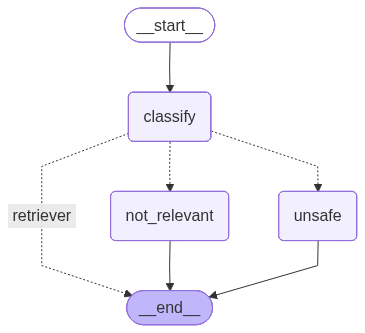

Classifier graph structure:
  START → classify → [not_relevant|unsafe|retriever]
    not_relevant → END
    unsafe → END
    retriever → END (for testing)


In [122]:
# CELL_ID: 07_generation_v2_visualize_classifier_graph
# ============================================================================
# VISUALIZE CLASSIFIER NODE GRAPH
# ============================================================================

from langgraph.graph import StateGraph, START, END

# Build standalone classifier graph
classifier_graph = StateGraph(GraphState)
classifier_graph.add_node("classify", classify_query)
classifier_graph.add_node("not_relevant", create_not_relevant_response)
classifier_graph.add_node("unsafe", create_unsafe_response)

classifier_graph.set_entry_point("classify")
classifier_graph.add_conditional_edges(
    "classify",
    route_classifier,
    {
        "not_relevant": "not_relevant",
        "unsafe": "unsafe",
        "retriever": END  # Route to END for standalone testing
    }
)
classifier_graph.add_edge("not_relevant", END)
classifier_graph.add_edge("unsafe", END)

classifier_app = classifier_graph.compile()

# Visualize
try:
    from IPython.display import Image, display
    graph_image = classifier_app.get_graph().draw_mermaid_png()
    display(Image(graph_image))
except Exception as e:
    print(f"Visualization error: {e}")

print("Classifier graph structure:")
print("  START → classify → [not_relevant|unsafe|retriever]")
print("    not_relevant → END")
print("    unsafe → END")
print("    retriever → END (for testing)")


In [59]:
# CELL_ID: 07_generation_v2_test_classifier_1
# ============================================================================
# TEST CLASSIFIER: RELEVANT AND SAFE QUERY
# ============================================================================

query_1 = "How is type 2 diabetes diagnosed?"

initial_state = {
    "query": query_1,
    "conversation_history": [],
    "previous_chunks": [],
    "classification": None,
    "retrieval_result": None,
    "generation": None,
    "summary": None,
    "retrieval_iterations": 0,
    "generation_iterations": 0,
    "total_tokens": 0,
    "retriever_agent_messages": None,
    "final_response": None,
    "error": None
}

result = classifier_app.invoke(initial_state)

# Output raw results
print("Query:", query_1)
print("\nResult state:")
print(result)


✓ Query classified: Relevant=True, Safe=True, Risk=none
  Reasoning: The query is a general, relevant question about diabetes diagnosis that does not require personalize...
Query: How is type 2 diabetes diagnosed?

Result state:
{'query': 'How is type 2 diabetes diagnosed?', 'conversation_history': [], 'previous_chunks': [], 'classification': QuerySafetyClassification(is_relevant=True, is_safe=True, risk_level='none', reasoning='The query is a general, relevant question about diabetes diagnosis that does not require personalized medical advice or risk assessment.'), 'retrieval_result': None, 'generation': None, 'summary': None, 'retrieval_iterations': 0, 'generation_iterations': 0, 'total_tokens': 0, 'retriever_agent_messages': None, 'final_response': None, 'error': None}


In [60]:
# CELL_ID: 07_generation_v2_test_classifier_2
# ============================================================================
# TEST CLASSIFIER: NOT RELEVANT QUERY
# ============================================================================

query_2 = "What is the weather today?"

initial_state = {
    "query": query_2,
    "conversation_history": [],
    "previous_chunks": [],
    "classification": None,
    "retrieval_result": None,
    "generation": None,
    "summary": None,
    "retrieval_iterations": 0,
    "generation_iterations": 0,
    "total_tokens": 0,
    "retriever_agent_messages": None,
    "final_response": None,
    "error": None
}

result = classifier_app.invoke(initial_state)

# Output raw results
print("Query:", query_2)
print("\nResult state:")
print(result)


✓ Query classified: Not relevant to diabetes
  Reasoning: The query 'What is the weather today?' is not related to diabetes management, treatment, diagnosis, ...
Query: What is the weather today?

Result state:
{'query': 'What is the weather today?', 'conversation_history': [], 'previous_chunks': [], 'classification': QuerySafetyClassification(is_relevant=False, is_safe=False, risk_level='none', reasoning="The query 'What is the weather today?' is not related to diabetes management, treatment, diagnosis, prevention, or any other healthcare topics associated with diabetes. It pertains to general weather information and is therefore not relevant to diabetes."), 'retrieval_result': None, 'generation': None, 'summary': None, 'retrieval_iterations': 0, 'generation_iterations': 0, 'total_tokens': 0, 'retriever_agent_messages': None, 'final_response': "I'm a diabetes specialist assistant. I can only provide information about diabetes management, treatment, diagnosis, prevention, and related h

In [61]:
# CELL_ID: 07_generation_v2_test_classifier_3
# ============================================================================
# TEST CLASSIFIER: UNSAFE QUERY
# ============================================================================

query_3 = "My patient has diabetes and blood pressure, will they die?"

initial_state = {
    "query": query_3,
    "conversation_history": [],
    "previous_chunks": [],
    "classification": None,
    "retrieval_result": None,
    "generation": None,
    "summary": None,
    "retrieval_iterations": 0,
    "generation_iterations": 0,
    "total_tokens": 0,
    "retriever_agent_messages": None,
    "final_response": None,
    "error": None
}

result = classifier_app.invoke(initial_state)

# Output raw results
print("Query:", query_3)
print("\nResult state:")
print(result)


✓ Query classified: Relevant=True, Safe=False, Risk=high
  Reasoning: The query asks about a specific patient's potential death due to diabetes and blood pressure, which ...
Query: My patient has diabetes and blood pressure, will they die?

Result state:
{'query': 'My patient has diabetes and blood pressure, will they die?', 'conversation_history': [], 'previous_chunks': [], 'classification': QuerySafetyClassification(is_relevant=True, is_safe=False, risk_level='high', reasoning="The query asks about a specific patient's potential death due to diabetes and blood pressure, which is a sensitive personal medical question requiring individualized assessment. It also implies a high risk outcome that should not be speculated upon without proper clinical context."), 'retrieval_result': None, 'generation': None, 'summary': None, 'retrieval_iterations': 0, 'generation_iterations': 0, 'total_tokens': 0, 'retriever_agent_messages': None, 'final_response': "I cannot answer this question as it pose

In [62]:
# CELL_ID: 07_generation_v2_test_classifier_4
# ============================================================================
# TEST CLASSIFIER: SAFE AND RELEVANT (TREATMENT QUESTION)
# ============================================================================

query_4 = "What are the treatment options for type 2 diabetes?"

initial_state = {
    "query": query_4,
    "conversation_history": [],
    "previous_chunks": [],
    "classification": None,
    "retrieval_result": None,
    "generation": None,
    "summary": None,
    "retrieval_iterations": 0,
    "generation_iterations": 0,
    "total_tokens": 0,
    "retriever_agent_messages": None,
    "final_response": None,
    "error": None
}

result = classifier_app.invoke(initial_state)

# Output raw results
print("Query:", query_4)
print("\nResult state:")
print(result)


✓ Query classified: Relevant=True, Safe=True, Risk=none
  Reasoning: The query is a general, relevant question about diabetes treatment options that does not require per...
Query: What are the treatment options for type 2 diabetes?

Result state:
{'query': 'What are the treatment options for type 2 diabetes?', 'conversation_history': [], 'previous_chunks': [], 'classification': QuerySafetyClassification(is_relevant=True, is_safe=True, risk_level='none', reasoning='The query is a general, relevant question about diabetes treatment options that does not require personalized medical advice or diagnosis. It poses no risk of harm.'), 'retrieval_result': None, 'generation': None, 'summary': None, 'retrieval_iterations': 0, 'generation_iterations': 0, 'total_tokens': 0, 'retriever_agent_messages': None, 'final_response': None, 'error': None}


In [123]:
# CELL_ID: 07_generation_v2_retriever_agent_prompt
# ============================================================================
# RETRIEVER AGENT SYSTEM PROMPT
# ============================================================================

def create_retriever_agent_system_prompt(document_structure: Dict, conversation_history: str = "") -> str:
    """
    Create system prompt for retriever agent with document structure context.
    Simplified to use only semantic search with query rephrasing.
    """
    # Get available chapters from document structure (for context only)
    chapters_list = list(document_structure.get("chapters", {}).keys())[:10]  # Limit to first 10
    
    prompt = f"""You are a retrieval agent for a diabetes knowledge management system. Your task is to retrieve relevant information from a vector database to answer user queries using semantic search.

## Available Tool

You have access to one retrieval tool:

**search_semantic_only**: Search using semantic similarity
   - Finds chunks that are semantically similar to your query
   - Returns chunks with relevance scores above 0.4
   - Use this tool for all searches

## Document Structure Context

Available chapters (sample):
{chr(10).join(f"- {chapter}" for chapter in chapters_list[:5])}
... (and {len(chapters_list) - 5 if len(chapters_list) > 5 else 0} more chapters)

## Your Process

1. **Analyze the query**: Understand what information is needed
2. **Search**: Call search_semantic_only with the query
3. **Evaluate results**: Assess if retrieved chunks are sufficient to answer the query
4. **Rephrase if needed**: If insufficient, rephrase the query to be more specific or use different terms, then search again
5. **Iterate**: You can try up to 3 times with different query rephrasings

## Important Guidelines

- Always use search_semantic_only for all searches
- If results are insufficient, rephrase the query and try again
- When rephrasing, try:
  - Using more specific terms
  - Using synonyms or related medical terms
  - Breaking down complex queries into simpler aspects
  - Focusing on key concepts from the original query
- Maximum 3 retrieval iterations
- Track your rephrased queries so they can be logged

{conversation_history if conversation_history else ""}

Remember: Your goal is to retrieve sufficient, relevant information to answer the user's query accurately. If initial results are insufficient, rephrase the query and search again."""
    
    return prompt

print("✓ Retriever agent system prompt function created")


✓ Retriever agent system prompt function created


In [125]:
# CELL_ID: 07_generation_v2_extract_agent_decisions
# ============================================================================
# HELPER: EXTRACT RETRIEVAL DECISIONS FROM AGENT MESSAGES
# ============================================================================

def extract_retrieval_decisions_from_messages(messages: List) -> Dict[str, Any]:
    """
    Extract query rephrasings and tool calls from agent messages.
    Simplified to track only semantic search with query rephrasing.
    
    Args:
        messages: List of messages from agent execution
        
    Returns:
        Dictionary with:
        - refined_query: Final query text used
        - rephrased_queries: List of all query rephrasings attempted
        - tool_calls_made: List of tool call dictionaries
    """
    refined_query = None
    rephrased_queries = []
    tool_calls_made = []
    
    # Track tool calls and query rephrasings
    for i, msg in enumerate(messages):
        # Check for AIMessage with tool calls
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tool_call in msg.tool_calls:
                # Handle both dict and object formats
                if isinstance(tool_call, dict):
                    tool_name = tool_call.get("name", "")
                    tool_args = tool_call.get("args", {})
                else:
                    # Object format (from LangChain)
                    tool_name = getattr(tool_call, "name", "")
                    tool_args = getattr(tool_call, "args", {})
                    # If args is a dict-like object, convert to dict
                    if hasattr(tool_args, 'dict'):
                        tool_args = tool_args.dict()
                    elif not isinstance(tool_args, dict):
                        tool_args = {}
                
                # Only track semantic search tool
                if tool_name == "search_semantic_only":
                    query_used = tool_args.get("query", "")
                    if query_used:
                        refined_query = query_used
                        # Track rephrased queries (avoid duplicates)
                        if query_used not in rephrased_queries:
                            rephrased_queries.append(query_used)
                
                # Store all tool call info
                tool_calls_made.append({
                    "tool_name": tool_name,
                    "args": tool_args,
                    "iteration": len(tool_calls_made) + 1
                })
    
    return {
        "refined_query": refined_query,
        "rephrased_queries": rephrased_queries,
        "tool_calls_made": tool_calls_made
    }

print("✓ Helper function to extract agent decisions created")


✓ Helper function to extract agent decisions created


In [136]:
# CELL_ID: 07_generation_v2_format_response_node
# ============================================================================
# FORMAT RESPONSE NODE
# ============================================================================

def format_response(state: GraphState) -> GraphState:
    """Format the final response with sources as hyperlinks."""
    result = state.get("retriever_generator_result")
    if not result:
        state["final_response"] = "Error: No result to format."
        return state
    
    # Start with the answer
    formatted = result.answer
    
    # Add sources section with hyperlinks
    if result.sources:
        formatted += "\n\n## Sources\n\n"
        for i, source in enumerate(result.sources[:10], 1):  # Top 10 sources
            # Handle both url_path and url metadata fields
            url = source.url if source.url else ""
            # Format as markdown hyperlink: [Title](url)
            if url:
                formatted += f"{i}. [{source.title}]({url})\n"
            else:
                formatted += f"{i}. {source.title}\n"
    
    state["final_response"] = formatted
    return state

print("✓ Format response node defined")


✓ Format response node defined


In [140]:
# CELL_ID: 07_generation_v2_retriever_generator_node
# ============================================================================
# COMBINED RETRIEVER-GENERATOR NODE (REACT AGENT)
# ============================================================================

def retrieve_and_generate(state: GraphState) -> GraphState:
    """
    Combined retriever-generator node using create_agent (LangChain v1 ReAct agent).
    Agent can retrieve information, generate answers, and critique them iteratively.
    
    Process:
    1. Check if previous chunks are sufficient (for follow-up queries)
    2. Create agent with three tools: search_semantic_only, generate_answer_from_chunks, critique_answer
    3. Agent orchestrates: search → generate → critique → search more if needed
    4. Continue until sufficient answer or max iterations (5 total)
    5. Extract final answer, chunks, critique from agent messages
    6. Return RetrieverGeneratorResult with all information
    """
    writer = get_stream_writer()
    query = state["query"]
    previous_chunks = state.get("previous_chunks", [])
    conversation_history = state.get("conversation_history", [])
    agent_iterations = state.get("agent_iterations", 0)
    max_iterations = 5
    
    # Format conversation history for context
    history_text = ""
    if conversation_history:
        history_text = "Conversation History:\n"
        for msg in conversation_history[-3:]:
            role = msg.get("role", "unknown")
            content = msg.get("content", "")[:200]
            history_text += f"{role.capitalize()}: {content}\n"
    
    # Format previous chunks if available
    previous_chunks_text = ""
    if previous_chunks:
        previous_chunks_text = "Previously Retrieved Chunks:\n"
        for i, chunk in enumerate(previous_chunks[:3], 1):
            metadata = chunk.get("metadata", {})
            title = metadata.get("title", "N/A")
            content_preview = chunk.get("content", "")[:200]
            previous_chunks_text += f"Chunk {i}: {title}\n{content_preview}...\n---\n"
    
    try:
        # First, evaluate if previous chunks are sufficient (for follow-up queries)
        # If sufficient, generate answer directly without new retrieval
        # NOTE: When calling @tool decorated functions directly (not through agent),
        # they return values directly (not wrapped in ToolMessage)
        # runtime=None is fine for direct calls - tools handle it gracefully
        if previous_chunks and agent_iterations == 0:
            # Try to generate answer from previous chunks
            try:
                # Format conversation context
                conv_context = history_text if history_text else ""
                
                # Generate answer from previous chunks
                # Direct function call (not through agent) - returns string directly
                answer = generate_answer_from_chunks(
                    query=query,
                    chunks=previous_chunks,
                    user_aim="To answer the user's query about diabetes management",
                    conversation_context=conv_context,
                    runtime=None  # No runtime in direct call - tool handles None gracefully
                )
                
                # Critique the answer
                # Direct function call - returns dict directly (not ToolMessage)
                critique_dict = critique_answer(
                    query=query,
                    answer=answer,
                    chunks=previous_chunks,
                    user_aim="To answer the user's query about diabetes management",
                    runtime=None  # No runtime in direct call
                )
                
                # If critique says it's complete, use previous chunks
                if critique_dict.get("is_complete", False):
                    # Create sources
                    sources_list = []
                    for chunk in previous_chunks[:10]:
                        metadata = chunk.get("metadata", {})
                        sources_list.append(Source(
                            title=metadata.get("title", "Unknown"),
                            url=metadata.get("url", ""),
                            chunk_id=chunk.get("chunk_id", ""),
                            relevance_score=chunk.get("relevance_score", 0.0)
                        ))
                    
                    # Create critique object
                    critique_obj = AnswerCritique(
                        is_factual=critique_dict.get("is_factual", False),
                        is_relevant=critique_dict.get("is_complete", False),
                        is_safe=critique_dict.get("is_safe", True),
                        concerns=critique_dict.get("concerns", []),
                        recommendations=critique_dict.get("recommendations", []),
                        should_regenerate=critique_dict.get("should_regenerate", False)
                    )
                    
                    result = RetrieverGeneratorResult(
                        answer=answer,
                        sources=sources_list,
                        retrieved_chunks=previous_chunks,
                        query_rephrasings=[query],
                        sufficient_info=True,
                        reasoning="Used previous chunks - sufficient information available.",
                        iterations=0,
                        tool_calls_made=[],
                        final_critique=critique_obj
                    )
                    
                    state["retriever_generator_result"] = result
                    state["agent_iterations"] = 0
                    print(f"✓ Using previous chunks (sufficient info)")
                    if writer:
                        writer({"type": "agent_decision", "message": "Using previous chunks"})
                    return state
            except Exception as e:
                # If evaluation fails, proceed with new retrieval
                print(f"  Previous chunks evaluation failed, will retrieve new: {e}")
                pass
        
        # Create agent with three tools: search, generate, critique
        agent_tools = [search_semantic_only, generate_answer_from_chunks, critique_answer]
        
        # Ensure create_agent is imported
        try:
            from langchain.agents import create_agent
        except ImportError:
            raise ImportError(
                "create_agent not found. Please ensure langchain.agents.create_agent is available. "
                "Make sure the imports cell has been executed."
            )
        
        # NOTE: llm is a ChatOllama model instance (compatible with create_agent's 'model' parameter)
        # create_agent expects: create_agent(model, tools, system_prompt=...)
        # Our llm variable is a model instance, so this is correct
        
        # Create system prompt for combined retriever-generator agent
        system_prompt = f"""You are a diabetes specialist assistant helping doctors make informed decisions. Your goal is to retrieve relevant information, generate comprehensive answers, and ensure they are complete and accurate.

## Available Tools

1. **search_semantic_only**: Search the knowledge base using semantic similarity
   - Use this to find relevant information about the query
   - Only chunks with similarity > 0.4 are returned
   - You can rephrase queries and search multiple times if needed

2. **generate_answer_from_chunks**: Generate an answer from retrieved chunks
   - Use this after retrieving chunks to create a comprehensive answer
   - Provide the query, chunks, user's aim, and conversation context
   - The tool will format chunks and generate an answer

3. **critique_answer**: Critique an answer for completeness, accuracy, and safety
   - Use this after generating an answer to evaluate its quality
   - The critique will tell you if more information is needed
   - If critique indicates gaps, retrieve more information and regenerate

## Your Process

1. **Understand the query**: Analyze what the user is asking and what they aim to learn
2. **Search for information**: Use search_semantic_only to find relevant chunks
3. **Generate answer**: Use generate_answer_from_chunks with the retrieved chunks
4. **Critique answer**: Use critique_answer to evaluate the generated answer
5. **Iterate if needed**: If critique indicates more info is needed, search again with different/rephrased queries
6. **Finalize**: When you have a complete, factual, and safe answer, provide it to the user

## Important Guidelines

- Only use chunks with similarity > 0.4 (already filtered by the tool)
- If initial search doesn't yield sufficient information, rephrase the query and search again
- Always critique your generated answers before finalizing
- If critique indicates missing information, retrieve more chunks
- Maximum 5 total iterations (search + generate + critique cycles) - this is guidance, stop when you have a complete answer
- When you have a sufficient answer, provide it directly without tool calls (this signals completion)

{history_text if history_text else ""}

Remember: Your goal is to provide safe, comprehensive, and factual answers based on the Kenya National Clinical Guidelines for Diabetes Management."""
        
        # Create agent
        agent = create_agent(
            llm,
            agent_tools,
            system_prompt=system_prompt
        )
        
        # Prepare initial user query
        user_query = f"""Query: {query}

{previous_chunks_text if previous_chunks_text else ""}

Your task: Retrieve relevant information, generate a comprehensive answer, and ensure it is complete, factual, and safe.

Process:
1. Search for relevant information using search_semantic_only
2. Generate an answer using generate_answer_from_chunks
3. Critique the answer using critique_answer
4. If critique indicates more information is needed, search again and regenerate
5. Continue until you have a complete answer or determine information is insufficient

Begin by searching for information to answer: {query}"""
        
        # Prepare messages for agent
        agent_messages = []
        
        # Add conversation history context
        if conversation_history:
            for msg in conversation_history[-3:]:
                role = msg.get("role", "user" if msg.get("role") == "user" else "assistant")
                content = msg.get("content", "")
                if role == "user":
                    agent_messages.append(HumanMessage(content=content))
                else:
                    agent_messages.append(AIMessage(content=content))
        
        agent_messages.append(HumanMessage(content=user_query))
        
        # Invoke agent - let it control the flow
        all_retrieved_chunks = []
        all_agent_messages = []
        final_answer = None
        final_critique = None
        query_rephrasings = []
        tool_calls_made = []
        
        if writer:
            writer({"type": "agent_start", "message": "Starting retriever-generator agent"})
        
        try:
            # Invoke agent - it will iterate internally up to max_iterations
            agent_result = agent.invoke({"messages": agent_messages})
            agent_messages_from_run = agent_result.get("messages", [])
            all_agent_messages.extend(agent_messages_from_run)
            
            # Extract information from agent messages
            current_chunks = []
            current_answer = None
            current_user_aim = "To answer the user's query about diabetes management"
            
            for msg in agent_messages_from_run:
                # Track tool calls
                if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
                    for tool_call in msg.tool_calls:
                        if isinstance(tool_call, dict):
                            tool_name = tool_call.get("name", "")
                            tool_args = tool_call.get("args", {})
                        else:
                            tool_name = getattr(tool_call, "name", "")
                            tool_args = getattr(tool_call, "args", {})
                            if hasattr(tool_args, 'dict'):
                                tool_args = tool_args.dict()
                            elif not isinstance(tool_args, dict):
                                tool_args = {}
                        
                        tool_calls_made.append({
                            "tool_name": tool_name,
                            "args": tool_args,
                            "iteration": len(tool_calls_made) + 1
                        })
                        
                        # Track query rephrasings from search_semantic_only
                        if tool_name == "search_semantic_only":
                            query_used = tool_args.get("query", "")
                            if query_used and query_used not in query_rephrasings:
                                query_rephrasings.append(query_used)
                
                # Extract chunks from ToolMessage (search_semantic_only results)
                # NOTE: ToolMessage content is typically a string (JSON serialized)
                # LangChain serializes tool return values to strings
                if isinstance(msg, ToolMessage):
                    content = msg.content
                    # Handle string content (most common case - JSON serialized)
                    if isinstance(content, str):
                        try:
                            import json
                            chunks_data = json.loads(content)
                            if isinstance(chunks_data, list):
                                for chunk in chunks_data:
                                    if isinstance(chunk, dict) and chunk.get("relevance_score", 0.0) > 0.4:
                                        chunk_id = chunk.get("chunk_id")
                                        if chunk_id and chunk_id not in [c.get("chunk_id") for c in all_retrieved_chunks]:
                                            all_retrieved_chunks.append(chunk)
                                            current_chunks.append(chunk)
                        except (json.JSONDecodeError, TypeError) as e:
                            # Not JSON or parsing failed - log but continue
                            if writer:
                                writer({"type": "tool_extraction_warning", "message": f"Could not parse chunks from tool result: {str(e)[:100]}"})
                            pass
                    # Handle direct list (unlikely but possible in some edge cases)
                    elif isinstance(content, list):
                        for chunk in content:
                            if isinstance(chunk, dict) and "chunk_id" in chunk:
                                # Filter chunks with similarity > 0.4
                                if chunk.get("relevance_score", 0.0) > 0.4:
                                    chunk_id = chunk.get("chunk_id")
                                    if chunk_id and chunk_id not in [c.get("chunk_id") for c in all_retrieved_chunks]:
                                        all_retrieved_chunks.append(chunk)
                                        current_chunks.append(chunk)
                
                # Extract answer from ToolMessage (generate_answer_from_chunks results)
                if isinstance(msg, ToolMessage):
                    # Check if this is from generate_answer_from_chunks
                    # ToolMessage doesn't have tool_call_id directly, need to check previous AIMessage
                    # For now, check if content looks like an answer (not a list, not a dict)
                    content = msg.content
                    if isinstance(content, str) and len(content) > 50 and not content.startswith("Error"):
                        # Likely an answer - check if it's from generate_answer_from_chunks
                        # We'll track the most recent answer
                        if "Error" not in content:
                            current_answer = content
            
            # Extract final answer from last AIMessage (when agent finishes)
            # CRITICAL FIX: AIMessage always has tool_calls attribute (it's a list)
            # Check if the list is empty (no tool calls = final answer)
            for msg in reversed(agent_messages_from_run):
                if isinstance(msg, AIMessage) and msg.content:
                    # Check if no tool calls (empty list means final answer)
                    if not msg.tool_calls or len(msg.tool_calls) == 0:
                        # Final answer from agent (no more tool calls)
                        final_answer = msg.content
                        break
            
            # Extract final critique from last critique_answer tool result
            # CRITICAL FIX: ToolMessage content is always a STRING (JSON serialized)
            # Must parse JSON to access dict fields
            for msg in reversed(agent_messages_from_run):
                if isinstance(msg, ToolMessage):
                    content = msg.content
                    # ToolMessage content is a string - parse JSON if it's from critique_answer
                    if isinstance(content, str):
                        try:
                            import json
                            content_dict = json.loads(content)
                            if isinstance(content_dict, dict) and "is_complete" in content_dict:
                                # This is from critique_answer - create AnswerCritique object
                                final_critique = AnswerCritique(
                                    is_factual=content_dict.get("is_factual", False),
                                    is_relevant=content_dict.get("is_complete", False),  # is_complete implies is_relevant
                                    is_safe=content_dict.get("is_safe", True),
                                    concerns=content_dict.get("concerns", []),
                                    recommendations=content_dict.get("recommendations", []),
                                    should_regenerate=content_dict.get("should_regenerate", False)
                                )
                                break
                        except (json.JSONDecodeError, TypeError):
                            # Not JSON or not from critique_answer - skip
                            pass
                    # Also handle direct dict (unlikely but possible in some cases)
                    elif isinstance(content, dict) and "is_complete" in content:
                        final_critique = AnswerCritique(
                            is_factual=content.get("is_factual", False),
                            is_relevant=content.get("is_complete", False),
                            is_safe=content.get("is_safe", True),
                            concerns=content.get("concerns", []),
                            recommendations=content.get("recommendations", []),
                            should_regenerate=content.get("should_regenerate", False)
                        )
                        break
            
            # Determine sufficiency
            # CRITICAL FIX: AnswerCritique doesn't have 'is_complete' attribute
            # Use is_factual, is_relevant, and should_regenerate instead
            sufficient_info = (
                final_answer is not None and
                len(final_answer) > 50 and
                (final_critique is None or (
                    final_critique.is_factual and 
                    final_critique.is_relevant and 
                    not final_critique.should_regenerate
                ))
            )
            
            # If no final answer but we have chunks, mark as insufficient
            if not final_answer and all_retrieved_chunks:
                sufficient_info = False
                final_answer = "Unable to generate a complete answer from the retrieved information."
            
            # If no chunks at all, mark as insufficient
            if not all_retrieved_chunks:
                sufficient_info = False
                final_answer = "No relevant information found in the knowledge base."
            
            # Create sources from chunks
            sources_list = []
            for chunk in all_retrieved_chunks[:10]:  # Limit to top 10 sources
                metadata = chunk.get("metadata", {})
                sources_list.append(Source(
                    title=metadata.get("title", "Unknown"),
                    url=metadata.get("url", ""),
                    chunk_id=chunk.get("chunk_id", ""),
                    relevance_score=chunk.get("relevance_score", 0.0)
                ))
            
            # Create RetrieverGeneratorResult
            result = RetrieverGeneratorResult(
                answer=final_answer or "Unable to generate answer.",
                sources=sources_list,
                retrieved_chunks=all_retrieved_chunks,
                query_rephrasings=query_rephrasings if query_rephrasings else [query],
                sufficient_info=sufficient_info,
                reasoning=f"Processed query through {len(tool_calls_made)} tool calls. {'Sufficient information obtained.' if sufficient_info else 'Insufficient information or unable to generate complete answer.'}",
                iterations=len(tool_calls_made),
                tool_calls_made=tool_calls_made,
                final_critique=final_critique
            )
            
            state["retriever_generator_result"] = result
            state["agent_iterations"] = len(tool_calls_made)
            state["retriever_agent_messages"] = all_agent_messages
            
            if writer:
                writer({
                    "type": "agent_complete",
                    "message": f"Answer generated: {len(final_answer) if final_answer else 0} chars, Chunks: {len(all_retrieved_chunks)}, Sufficient: {sufficient_info}"
                })
            
            print(f"✓ Combined node complete: Answer={len(final_answer) if final_answer else 0} chars, Chunks={len(all_retrieved_chunks)}, Sufficient={sufficient_info}")
            
        except Exception as agent_error:
            print(f"⚠ Agent execution error: {agent_error}")
            # Create error result
            result = RetrieverGeneratorResult(
                answer=f"Error during processing: {str(agent_error)[:200]}",
                sources=[],
                retrieved_chunks=all_retrieved_chunks,
                query_rephrasings=query_rephrasings,
                sufficient_info=False,
                reasoning=f"Agent encountered an error: {str(agent_error)[:200]}",
                iterations=len(tool_calls_made),
                tool_calls_made=tool_calls_made,
                final_critique=None
            )
            state["retriever_generator_result"] = result
            state["agent_iterations"] = len(tool_calls_made)
            state["retriever_agent_messages"] = all_agent_messages
            state["error"] = str(agent_error)
    
    except Exception as e:
        error_str = str(e)
        error_lower = error_str.lower()
        
        # Categorize errors
        is_transient = any(keyword in error_lower for keyword in [
            "timeout", "connection", "network", "rate limit", "temporary", 
            "retry", "unavailable", "service", "503", "502", "504"
        ])
        
        is_llm_recoverable = any(keyword in error_lower for keyword in [
            "parsing", "format", "json", "schema", "validation", "structure"
        ])
        
        # Create error result
        error_result = RetrieverGeneratorResult(
            answer=f"Error during processing: {error_str[:200]}",
            sources=[],
            retrieved_chunks=[],
            query_rephrasings=[query],
            sufficient_info=False,
            reasoning=f"Error occurred: {error_str[:200]}",
            iterations=0,
            tool_calls_made=[],
            final_critique=None
        )
        
        if is_transient:
            # Transient errors - will be retried by retry policy
            print(f"⚠ Transient error (will retry): {error_str[:100]}")
            error_result.reasoning = f"Temporary error occurred: {error_str[:200]}. System will retry automatically."
            # Don't set error state - let retry policy handle it
        elif is_llm_recoverable:
            # LLM-recoverable errors
            print(f"⚠ LLM-recoverable error: {error_str[:100]}")
            error_result.reasoning = f"Format/parsing issue: {error_str[:200]}. Please adjust query or parameters."
            state["error"] = f"LLM-recoverable: {error_str}"
        else:
            # Unexpected errors - bubble up for debugging
            print(f"⚠ Unexpected error: {error_str[:100]}")
            error_result.reasoning = f"Unexpected error: {error_str[:200]}"
            state["error"] = error_str
            # Re-raise unexpected errors for debugging
            raise
        
        state["retriever_generator_result"] = error_result
        state["agent_iterations"] = 0
        state["retriever_agent_messages"] = []
    
    return state


def route_retriever_generator(state: GraphState) -> str:
    """Route based on combined retriever-generator results."""
    result = state.get("retriever_generator_result")
    if not result:
        return "insufficient_info"
    
    if result.sufficient_info:
        return "format_response"  # Will go to format_response then monitor
    else:
        return "insufficient_info"


print("✓ Combined retriever-generator node defined")

✓ Combined retriever-generator node defined


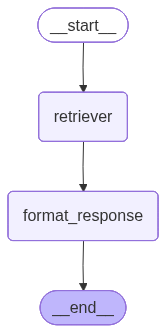

✓ Standalone retriever-generator test graph created

Graph structure:
  START → retriever → format_response → END


In [138]:
# CELL_ID: 07_generation_v2_standalone_test_graph
# ============================================================================
# STANDALONE RETRIEVER-GENERATOR TEST GRAPH
# ============================================================================

from langgraph.graph import StateGraph, START, END

# Build standalone retriever-generator test graph
# This bypasses the classifier for direct testing
retriever_test_graph = StateGraph(GraphState)

retriever_test_graph.add_node("retriever", retrieve_and_generate)
retriever_test_graph.add_node("format_response", format_response)

retriever_test_graph.set_entry_point("retriever")
retriever_test_graph.add_edge("retriever", "format_response")
retriever_test_graph.add_edge("format_response", END)

retriever_test_app = retriever_test_graph.compile()

# Visualize
try:
    from IPython.display import Image, display
    graph_image = retriever_test_app.get_graph().draw_mermaid_png()
    display(Image(graph_image))
except Exception as e:
    print(f"Visualization error: {e}")

print("✓ Standalone retriever-generator test graph created")
print("\nGraph structure:")
print("  START → retriever → format_response → END")


In [141]:
# CELL_ID: 07_generation_v2_test_retriever_generator_streaming
# ============================================================================
# TEST RETRIEVER-GENERATOR WORKFLOW WITH STREAMING
# ============================================================================

# Test query
test_query = "How is type 2 diabetes diagnosed?"

initial_state = {
    "query": test_query,
    "conversation_history": [],
    "previous_chunks": [],
    "classification": None,
    "retriever_generator_result": None,
    "summary": None,
    "agent_iterations": 0,
    "total_tokens": 0,
    "retriever_agent_messages": None,
    "final_response": None,
    "error": None
}

print("=" * 60)
print("RETRIEVER-GENERATOR TEST (WITH STREAMING)")
print("=" * 60)
print(f"Query: {test_query}\n")
print("Executing workflow with streaming...\n")
print("-" * 60)

# Track state for final result
final_state = None
accumulated_tokens = []
current_node = None

# Stream with multiple modes: updates, messages, and custom
for stream_mode, chunk in retriever_test_app.stream(
    initial_state,
    stream_mode=["updates", "messages", "custom"]
):
    # Handle updates mode - state changes after each node
    if stream_mode == "updates":
        for node_name, state_update in chunk.items():
            current_node = node_name
            print(f"\n[Node: {node_name}]")
            
            # Show what changed in state
            if "retriever_generator_result" in state_update:
                print("  → Retriever-generator result updated")
            if "final_response" in state_update:
                print("  → Final response formatted")
            
            # Update final_state
            if final_state is None:
                final_state = state_update.copy()
            else:
                final_state.update(state_update)
    
    # Handle messages mode - LLM tokens
    elif stream_mode == "messages":
        message_chunk, metadata = chunk
        # Extract node info from metadata
        node_info = metadata.get("langgraph_node", "unknown")
        
        # Stream tokens as they're generated
        if hasattr(message_chunk, "content") and message_chunk.content:
            token = message_chunk.content
            accumulated_tokens.append(token)
            # Print token immediately (flush for real-time display)
            print(token, end="", flush=True)
    
    # Handle custom mode - progress messages from tools/nodes
    elif stream_mode == "custom":
        # Custom data can be dict or string
        if isinstance(chunk, dict):
            msg_type = chunk.get("type", "progress")
            message = chunk.get("message", str(chunk))
            if msg_type == "tool_progress":
                print(f"\n[Tool] {message}")
            elif msg_type == "agent_decision":
                print(f"\n[Agent] {message}")
            elif msg_type == "agent_start":
                print(f"\n[Agent] {message}")
            elif msg_type == "agent_complete":
                print(f"\n[Agent] {message}")
            else:
                print(f"\n[Custom] {message}")
        else:
            print(f"\n[Custom] {chunk}")

print("\n" + "-" * 60)
print("\n" + "=" * 60)
print("FINAL RESPONSE")
print("=" * 60)

# Get final state if we have it, otherwise use the last update
if final_state is None:
    # Fallback: collect final state from last update
    final_state = initial_state.copy()
    for stream_mode, chunk in retriever_test_app.stream(
        initial_state,
        stream_mode="values"  # Get full state
    ):
        final_state = chunk
        break

# Display final formatted response
if final_state and final_state.get("final_response"):
    print(final_state["final_response"])
else:
    print("No response generated")

print("\n" + "=" * 60)

# Display additional info
if final_state and final_state.get("retriever_generator_result"):
    rg_result = final_state["retriever_generator_result"]
    print(f"\nAdditional Information:")
    print(f"  • Sufficient info: {rg_result.sufficient_info}")
    print(f"  • Iterations: {rg_result.iterations}")
    print(f"  • Chunks retrieved: {len(rg_result.retrieved_chunks)}")
    print(f"  • Sources: {len(rg_result.sources)}")
    if rg_result.query_rephrasings:
        print(f"  • Query rephrasings: {rg_result.query_rephrasings}")
    if accumulated_tokens:
        print(f"  • Total tokens streamed: {len(''.join(accumulated_tokens))} characters")
print("=" * 60)


RETRIEVER-GENERATOR TEST (WITH STREAMING)
Query: How is type 2 diabetes diagnosed?

Executing workflow with streaming...

------------------------------------------------------------

[Agent] Starting retriever-generator agent
⚠ Agent execution error: you've reached your hourly usage limit, please wait or upgrade to continue (status code: 429)

[Node: retriever]
  → Retriever-generator result updated
  → Final response formatted

[Node: format_response]
  → Retriever-generator result updated
  → Final response formatted

------------------------------------------------------------

FINAL RESPONSE
Error during processing: you've reached your hourly usage limit, please wait or upgrade to continue (status code: 429)


Additional Information:
  • Sufficient info: False
  • Iterations: 0
  • Chunks retrieved: 0
  • Sources: 0


In [139]:
# CELL_ID: 07_generation_v2_test_retriever_generator
# ============================================================================
# TEST RETRIEVER-GENERATOR WORKFLOW
# ============================================================================

# Test query
test_query = "How is type 2 diabetes diagnosed?"

initial_state = {
    "query": test_query,
    "conversation_history": [],
    "previous_chunks": [],
    "classification": None,
    "retriever_generator_result": None,
    "summary": None,
    "agent_iterations": 0,
    "total_tokens": 0,
    "retriever_agent_messages": None,
    "final_response": None,
    "error": None
}

print("=" * 60)
print("RETRIEVER-GENERATOR TEST")
print("=" * 60)
print(f"Query: {test_query}\n")
print("Executing workflow...\n")

result = retriever_test_app.invoke(initial_state)

print("=" * 60)
print("RESPONSE")
print("=" * 60)
print(result.get("final_response", "No response generated"))
print("\n" + "=" * 60)

# Display additional info
if result.get("retriever_generator_result"):
    rg_result = result["retriever_generator_result"]
    print(f"\nAdditional Information:")
    print(f"  • Sufficient info: {rg_result.sufficient_info}")
    print(f"  • Iterations: {rg_result.iterations}")
    print(f"  • Chunks retrieved: {len(rg_result.retrieved_chunks)}")
    print(f"  • Sources: {len(rg_result.sources)}")
    if rg_result.query_rephrasings:
        print(f"  • Query rephrasings: {rg_result.query_rephrasings}")
print("=" * 60)


RETRIEVER-GENERATOR TEST
Query: How is type 2 diabetes diagnosed?

Executing workflow...

✓ Combined node complete: Answer=3797 chars, Chunks=18, Sufficient=True
RESPONSE
Based on the information I've gathered from the Kenya National Clinical Guidelines, I can now provide you with a comprehensive answer about how type 2 diabetes is diagnosed.

## How Type 2 Diabetes is Diagnosed

### **1. Clinical Presentation & Initial Assessment**

Type 2 diabetes often presents insidiously with non-specific symptoms or may be discovered during routine screening. Many patients with type 2 diabetes may present with established chronic complications, making comprehensive history and examination crucial.

**Key Signs and Symptoms:**
- **More Common:** Weight loss, polyuria (in children: bedwetting), excessive thirst, tiredness/fatigue
- **Less Common:** Excessive hunger, blurred vision, mood changes, skin infections, oral or vaginal thrush, abdominal pain
- **Severe (Diabetic ketoacidosis):** Frequent v